# Self organizing maps

This is SOM but not SOM

We will start with a network that has 3 layers. The first layer is sensors. And the network will have a difference with standard artificial neural networks. 

The difference is that every neuron $i$ in the presynaptic layer has a matrix $W_i$ instead of having only one matrix $W$ for the whole layer. These matrices, $W_i$ connect the neuron $i$ with a subset of neurons in the next layer. This subset is a group of neurons located just above the neuron $i$ within a radius $r$.

In [1]:
import random

import torch
import torch.nn as nn
import torch.optim as optim

In [29]:
import math

input_x = 15
output_x = 9
radius = 4
for i in range(input_x):
    k = ((output_x - radius) / input_x) * i
    print(i, k, math.floor(k))

0 0.0 0
1 0.3333333333333333 0
2 0.6666666666666666 0
3 1.0 1
4 1.3333333333333333 1
5 1.6666666666666665 1
6 2.0 2
7 2.333333333333333 2
8 2.6666666666666665 2
9 3.0 3
10 3.333333333333333 3
11 3.6666666666666665 3
12 4.0 4
13 4.333333333333333 4
14 4.666666666666666 4


In [42]:
class ColumnLayer:
    def __init__(self, input_shape, output_shape, radius, init_std=0.01):
        """
        Initialize the network.
        
        Args:
            input_shape (tuple): Shape of the input layer (height, width).
            output_shape (tuple): Shape of the output layer (height, width).
            radius (int): Radius for the connection neighborhood.
            init_std (float): Standard deviation for weight initialization.
        """
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.radius = radius
        
        # Initialize weights for each neuron in the input grid
        self.weights = []
        for i in range(input_shape[0]):
            row_weights = []
            for j in range(input_shape[1]):
                w_shape = (self.radius, self.radius)
                row_weights.append(torch.randn(w_shape) * init_std)
            self.weights.append(row_weights)

    def area_position(self, x, y):
        row_start = math.floor(((self.output_shape[0] - self.radius) / self.input_shape[0]) * x)
        row_end = row_start + self.radius
        col_start = math.floor(((self.output_shape[1] - self.radius) / self.input_shape[1]) * y)
        col_end = col_start + self.radius
        
        return (slice(row_start, row_end), slice(col_start, col_end))
    
    def forward(self, input_grid):
        """
        Perform a forward pass of the network.
        
        Args:
            input_grid (torch.Tensor): Input tensor of shape (H_in, W_in).
        
        Returns:
            torch.Tensor: Output tensor of shape (H_out, W_out).
        """
        output_grid = torch.zeros(self.output_shape)
        
        for i in range(self.input_shape[0]):
            for j in range(self.input_shape[1]):
                weight = self.weights[i][j]
                (x_s, y_s) = self.area_position(i, j)
                output_slice = output_grid[x_s, y_s]
                
                # Update the output slice based on the weight and input
                output_slice += input_grid[i, j] * weight
                
        return output_grid

    def update_weights(self, x, y_t, learning_rate=0.05):
        """
        Manually update weights based on provided gradients.
        
        Args:
            gradients (list of lists of torch.Tensor): Gradient for each weight matrix.
            learning_rate (float): Learning rate for weight updates.
        """
        for i in range(self.input_shape[0]):
            for j in range(self.input_shape[1]):
                
                w = self.weights[i][j]
                (x_s, y_s) = self.area_position(i, j)
                oja = y_t * (x - y_t * w)
                self.weights[i][j] += learning_rate * gradients[i][j]



SyntaxError: invalid syntax (3941697281.py, line 64)

We have inputs to an Artificial Neural Network like these:

In [3]:
input = torch.tensor([
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [1, 1, 1, 1, 1]
], dtype=torch.float)

They represent some geometric objects. In this case it's a line.

The receptive field in our ANN will be bigger than this input. Every input is randomly moved.

So next, we take the input and create K=5 displacements (moving the original tensor in receptive field by (x,y) offset).

In [4]:
K = 5
N = 15

In [5]:
def create_displaced_tensors(tensor, K, receptive_field_size=(15, 15)):
    """
    Creates K displacements of the input tensor by moving it within a larger receptive field.
    
    Parameters:
        tensor (torch.Tensor): The original input tensor of shape (5, 5).
        K (int): The number of displacements to create.
        receptive_field_size (tuple): The dimensions of the receptive field (height, width).
        
    Returns:
        batch of tensors: A tensor of K tensors with the original tensor displaced within the receptive field.
    """
    
    # Create a larger tensor filled with zeros (the receptive field)
    receptive_field_h, receptive_field_w = receptive_field_size
    displaced_tensors = torch.zeros(K, receptive_field_h, receptive_field_w, dtype=tensor.dtype)
    
    # Calculate padding size based on the receptive field dimensions
    input_h, input_w = tensor.shape
    padding_h = receptive_field_h - input_h
    padding_w = receptive_field_w - input_w
    
    for i in range(K):
        # Randomly choose top-left corner for placing the input tensor within the receptive field
        max_x_offset = padding_h
        max_y_offset = padding_w
        x_offset = random.randint(0, max_x_offset)
        y_offset = random.randint(0, max_y_offset)
        
        # Place the input tensor within the receptive field at the chosen offset
        displaced_tensors[i, x_offset:x_offset + input_h, y_offset:y_offset + input_w] = tensor

    return displaced_tensors

input_saccades = create_displaced_tensors(input,
                                          K=K,
                                          receptive_field_size=(N, N))

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

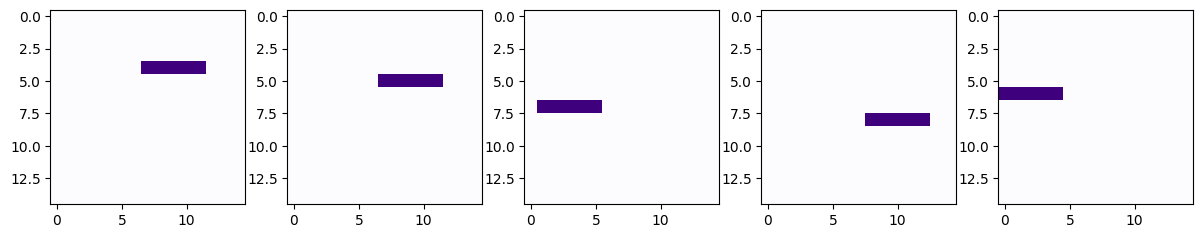

In [37]:
fig, axs = plt.subplots(1, K, figsize=(12, 4))
for i in range(K):
  axs[i].imshow(input_saccades[i].detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()


In [7]:
new_input = torch.tensor([
  [1, 1, 1, 1, 1],
  [1, 0, 0, 0, 1],
  [1, 0, 0, 0, 1],
  [1, 0, 0, 0, 1],
  [1, 1, 1, 1, 1]
], dtype=torch.float)
test_set = create_displaced_tensors(new_input,
                                    K=K,
                                    receptive_field_size=(N, N))

In [39]:
input_shape = (N, N)
output_shape = (8, 8)
radius = 4

layer = ColumnLayer(input_shape, output_shape, radius, init_std=0.01)

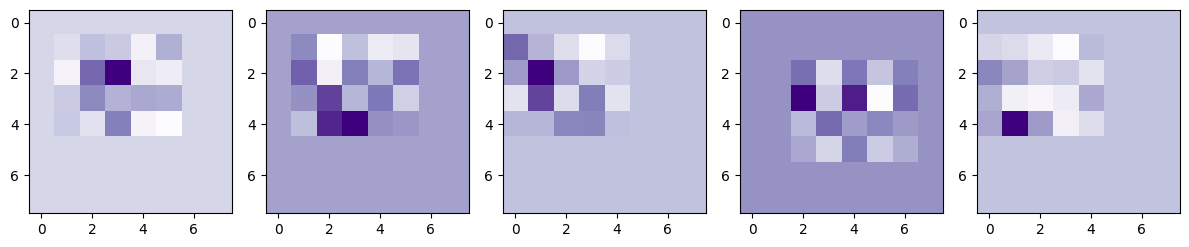

In [40]:
fig, axs = plt.subplots(1, K, figsize=(12, 4))
for i in range(K):
    x = input_saccades[i]
    y = layer.forward(x)
    y_t = y.unsqueeze(0).T
    layer.update_weights(x, y_t)
    axs[i].imshow(y.detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()

In [ ]:
def oja_update(self, activations):
    for i in range(len(activations) - 1):
        layer = self.layers[i]
        weight = layer.weight.data
        
        prev_layer_x = activations[i]
        curr_layer_y = activations[i + 1].unsqueeze(0).T

        weight += self.eta * curr_layer_y * (prev_layer_x - curr_layer_y * weight)

In [ ]:
model.eta = 0.5
model.tau = 0.4

fig, axs = plt.subplots(K, 5, figsize=(10, 10))

for i in range(K):
    x = input_saccades[i]
    y = model(x)
    z = model.forward_back(y[0], y[-1])
    model.oja_update_back(z, y)
    zz = model.forward_back(y[0], y[-1])
    
    # error = zz[3] - y[0]
    # latent_repr = y[-1]
    # latent_correction = 1.0 * torch.matmul(error.unsqueeze(0), model.inverse_layers[0].weight)
    
    
    axs[i,0].imshow(zz[0].view(2,-1).detach().numpy(), cmap=cm.Purples)
    axs[i,1].imshow(zz[1].view(4,4).detach().numpy(), cmap=cm.Purples)
    axs[i,2].imshow(zz[2].view(6,6).detach().numpy(), cmap=cm.Purples)
    axs[i,3].imshow(zz[3].view(15,15).detach().numpy(), cmap=cm.Purples)
    axs[i,4].imshow(x.view(15,15).detach().numpy(), cmap=cm.Purples)

plt.show()

In [ ]:
#x_r = per_layer_data[3]
a = model.forward_back(per_layer_data)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(a[0].view(2,-1).detach().numpy(), cmap=cm.Purples)
axs[1].imshow(a[1].view(4,4).detach().numpy(), cmap=cm.Purples)
axs[2].imshow(a[2].view(6,6).detach().numpy(), cmap=cm.Purples)
axs[3].imshow(a[3].view(15,15).detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()

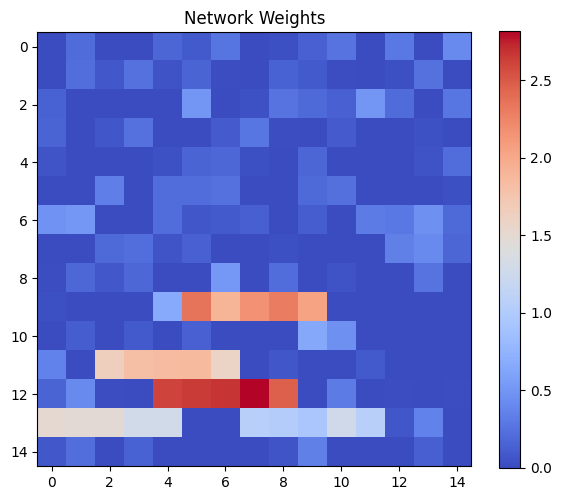

In [33]:
x = aa[3]
x
plt.figure(figsize=(6, 5))
x_mat = plt.imshow(x.view(15,15).detach().numpy(), cmap=cm.coolwarm)
plt.colorbar(x_mat)
plt.title("Network Weights")
plt.tight_layout()
plt.show()

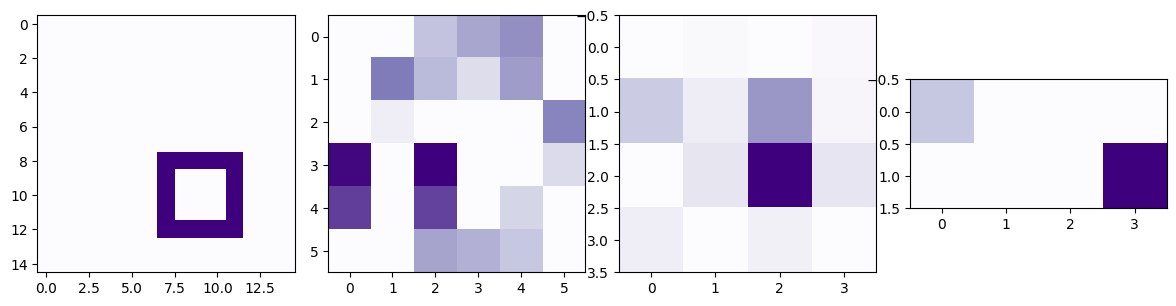

In [13]:
a = test_set[0]
per_layer_data = model(a)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(per_layer_data[0].view(15,15).detach().numpy(), cmap=cm.Purples)
axs[1].imshow(per_layer_data[1].view(6,6).detach().numpy(), cmap=cm.Purples)
axs[2].imshow(per_layer_data[2].view(4,4).detach().numpy(), cmap=cm.Purples)
axs[3].imshow(per_layer_data[3].view(2,-1).detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()

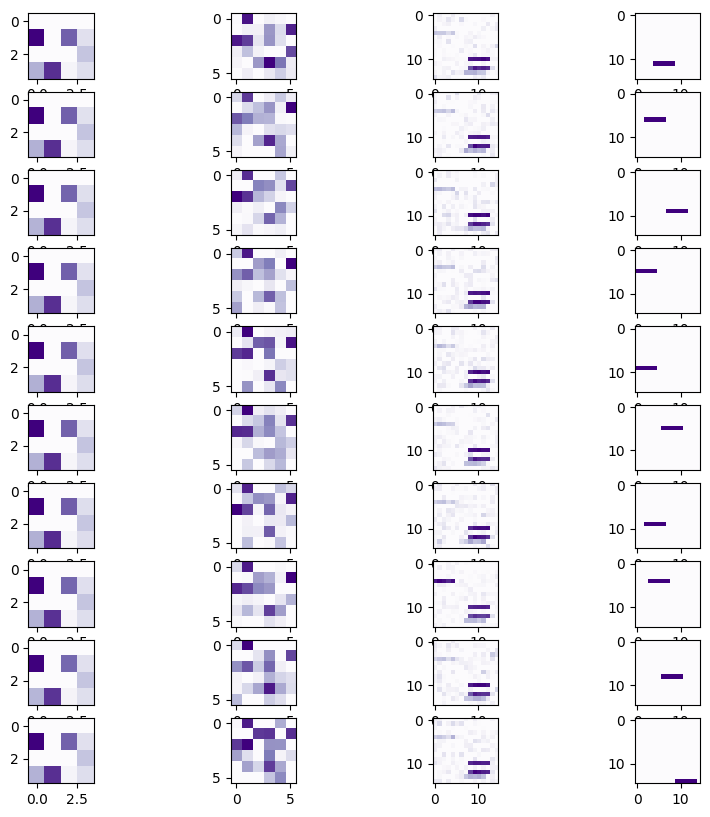

In [14]:
L = 10
test_saccades = create_displaced_tensors(input, K=L, receptive_field_size=(N, N))
fig, axs = plt.subplots(L, 4, figsize=(10, 10))
# x = test_set[0]

for i in range(L):
    x = test_saccades[i]
    # y0 = torch.zeros_like(input_saccades[k]).flatten()
    y = model(x)
    aa = model.forward_back(y[0], y[-1])

    axs[i,0].imshow(aa[1].view(4,4).detach().numpy(), cmap=cm.Purples)
    axs[i,1].imshow(aa[2].view(6,6).detach().numpy(), cmap=cm.Purples)
    axs[i,2].imshow(aa[3].view(15,15).detach().numpy(), cmap=cm.Purples)
    axs[i,3].imshow(y[0].view(15,15).detach().numpy(), cmap=cm.Purples)

plt.show()

In this hierarchical network with Oja's learning, there is nothing that represents connection between neurons on the same layer. 
And we still don't want to go down to CNN kernels because they are not biologically plausible.

We need to choose a method that can save relative positions between important neurons, meaning that these positions play a key role in recognizing an invariant.

In the brain, neurons within the same layer often have lateral (side-to-side) connections that modulate the influence they have on each other.

We can use attention-like matrix that is appplied to the embeddings

In [ ]:
# Apply lateral influence
x = torch.relu(x + torch.matmul(self.lateral_matrices[i], x))

In [107]:
# Define a grid adjacency matrix for lateral connections
def create_adjacency_matrix(size, distance_fn=lambda x, y: 1 / (1 + abs(x - y))):
    adj_matrix = torch.zeros((size, size))
    for i in range(size):
        for j in range(size):
            adj_matrix[i, j] = distance_fn(i, j)
    return adj_matrix

grid_adjacency_matrix = create_adjacency_matrix(32)  # Example for a 32-neuron layer

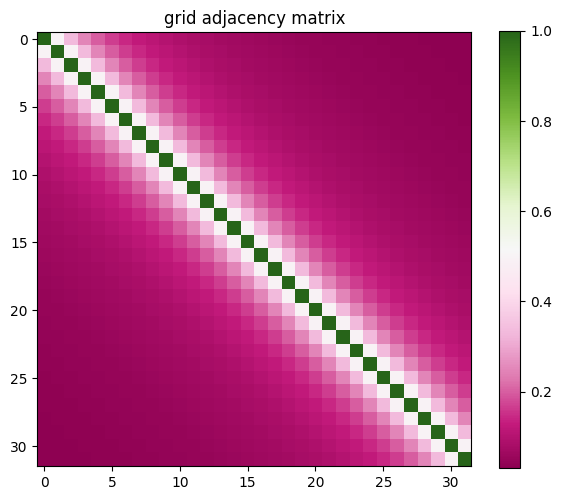

In [116]:
plt.figure(figsize=(6, 5))
w_mat = plt.imshow(grid_adjacency_matrix, cmap=cm.PiYG)
plt.colorbar(w_mat)
plt.title("grid adjacency matrix")
plt.tight_layout()
plt.show()

In Oja’s learning rule, weights tend to reinforce only excitatory (positive) connections because the rule inherently amplifies positive activations and drives down negative values. 
However, in a biologically inspired network, it's important to include both excitatory (positive) and inhibitory (negative) connections

## SOM

In [15]:
class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
    def __init__(self, m, n, dim, alpha=None, sigma=None):
        super(SOM, self).__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.n_neurons = self.m * self.n
        # gain coefficient
        self.alpha = 0.3
        # correction
        self.sigma = max(m, n) / 2.0
        
        if alpha is not None:
            self.alpha = float(alpha)
        if sigma is not None:
            self.sigma = float(sigma)

        self.weights = torch.randn(self.n_neurons, dim)
        self.locations = torch.tensor(np.array(list(self.make_grid_locations_iter(m, n))), dtype=torch.int32)
        self.pdist = nn.PairwiseDistance(p=2)

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def make_grid_locations_iter(self, m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(self.n_neurons)],
                            key=lambda x: np.linalg.norm(vect-self.weights[x]))
            to_return.append(self.locations[min_index])

        return to_return

    def forward(self, x, learning_rate_op):
        dists = self.pdist(x, self.weights) # compare X with every column in W. columns is a batch dimension
        bmu_index = dists.min(0).indices # find the minimum distance
        bmu_loc = self.locations[bmu_index,:]
        
        alpha_op = self.alpha * learning_rate_op
        sigma_op = self.sigma * learning_rate_op

        diff = self.locations - bmu_loc # .unsqueeze(0).repeat(self.n_neurons, 1) - don't need to copy because broadcasting will do it (ref: https://numpy.org/doc/stable/user/basics.broadcasting.html)
        bmu_distance_squares = torch.sum(torch.pow(diff.float(), 2), 1) # array where for every neuron i: x_i ^2 + y_i ^2 -> d_i
        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op**2))) # e^{ -(d_i / sigma^2) }
        gain_coefficient = alpha_op * neighbourhood_func
        learning_rate_multiplier = gain_coefficient.repeat(self.dim, 1).T # copy to every dimension
        delta = torch.mul(learning_rate_multiplier, x - self.weights) # (x - self.weights) - uses broadcasting too

        self.weights += delta
    
    def forward_no_training(self, x):
        # find a location where the distance between x and m_i is the minimum 
        min_index = torch.linalg.vector_norm(x - self.weights, ord=2, dim=1).min(0).indices
        return self.locations[min_index]

In [ ]:
batch_size = 100
n_iter = 5
som_dim = N * N
som = SOM(N, N, som_dim)

for iter_no in range(n_iter):
    data = create_displaced_tensors(input, K=batch_size, receptive_field_size=(N, N))
    # data dimension is 225 (15x15)
    for i in range(len(data)):
        learning_rate_op = 1.0 - iter_no/(1.0*n_iter)
        som(data[i], learning_rate_op)